In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid
from tqdm import tqdm, trange

In [2]:
experiment = 'CHIME'

In [3]:
from LIMxCMBL.experiments import *

In [4]:
zmin = experiments[experiment]['zmin']
zmax = experiments[experiment]['zmax']
line_str = experiments[experiment]['line_str']

Omega_field  =  experiments[experiment]['Omega_field'] #rad^2
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

kpar_fundamental = 2*np.pi/(chimax - chimin)

In [5]:
ell_fundamental = np.sqrt((2*np.pi)**2 / Omega_field.to(u.rad**2))
ell_fundamental = max(np.array(ell_fundamental), 10)

In [6]:
ell_fundamental

10

In [7]:
#I think its pi^2/Omega_pix not (2pi)^2/Omega_pix based on np.fft.rfftfreq output
ell_max_survey = np.sqrt((np.pi)**2 / experiments[experiment]['Omega_pix'].to(u.rad**2))
ell_max_survey = np.array(ell_max_survey)

In [8]:
ell_max_survey

array(270.)

In [9]:
Pei = max(experiments[experiment]['f_Pei']())
Pei = np.array(Pei) # kJy2 Mpc3 / sr2

In [10]:
Omega_field = np.array(Omega_field)

In [11]:
print(experiment)
print('zmin:',zmin)
print('zmax:',zmax)
print('Sky coverate[deg2]: %.1f'%(Omega_field/((np.pi/180)**2)))
print('White noise[kJy2 Mpc3 / sr2]: %.1f'%Pei)
print('ell sensitivity: %.1f to %.1f'%(ell_fundamental, ell_max_survey))

CHIME
zmin: 1.0
zmax: 1.3
Sky coverate[deg2]: 31000.0
White noise[kJy2 Mpc3 / sr2]: 0.3
ell sensitivity: 10.0 to 270.0


In [12]:
n_bins = 100
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [13]:
import matplotlib.pyplot as plt

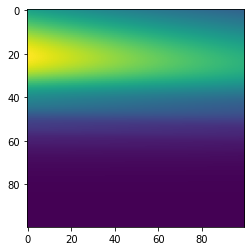

In [14]:
I_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_'
I_kappa_fname +='zmin_%.5f_zmax_%.5f_quad_next_%d.npy'%(zmin, 
                                                        zmax, 
                                                        1000)

I_kappa_unbinned = np.load(I_kappa_fname)

I_kappa = np.zeros((len(ells), n_bins))
external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 1000)
for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            I_kappa[:,i] = (np.sum(I_kappa_unbinned[:,idx1[0]:idx1[-1]+1,], 
                                 axis=(1)) / len(idx1))
            
plt.imshow(I_kappa)

In [15]:
def get_binned(base, n_external = 300):
    external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
    
    oup = np.zeros((100, n_bins, n_bins), dtype=np.float64)
    for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        for j, (l2, r2) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            idx2 = np.where((external_chis > l2) & (external_chis <= r2))[0]
            oup[:,i,j] = (np.sum(base[:,
                                      idx1[0]:idx1[-1]+1,
                                      idx2[0]:idx2[-1]+1], 
                                 axis=(1, 2)) / len(idx1) / len(idx2))
    return oup

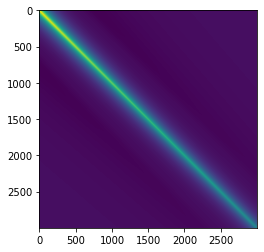

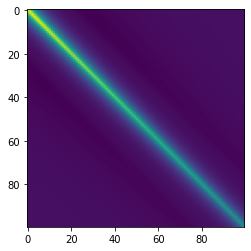

In [16]:
#get <II>

I_I_unbinned = np.load('/scratch/users/delon/LIMxCMBL/I_auto/'+
                          'I_auto_n_ext_%d_zmin_%.1f_zmax_%.1f.npy'%(3000, 
                                                                     zmin, 
                                                                     zmax))

plt.imshow(I_I_unbinned[0])
plt.show()
I_I = get_binned(I_I_unbinned, n_external = 3000)
plt.imshow(I_I[0])

[]

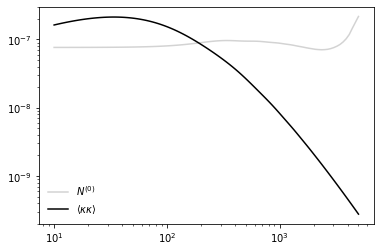

In [17]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) # dimensionless


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, f_N0(ells), c='lightgrey', label=r'$N^{(0)}$')
plt.plot(ells, ClKK, c='k', label=r'$\langle \kappa\kappa\rangle$')
plt.legend(frameon=False)
plt.loglog()

In [18]:
SNR2_per_mode_full = {}
SNR2_per_mode_noise_dom = {}

# full cov no filtering SNR per mode

In [19]:
from LIMxCMBL.noise import f_eIeI
cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * np.diag(f_eIeI(chi=chi_bin_centers, dchi=dchi_binned, Lambda=0)))
cov += np.einsum('l  ,lxy->lxy', (ClKK + f_N0(ells)),  I_I)
cov += np.einsum('lx ,l y->lxy', I_kappa, I_kappa)
cov = cov.astype(np.float64)

SNR2_per_mode_full[0.0] = np.zeros_like(ells)
for ell_idx in range(len(ells)):
    L = np.linalg.cholesky(cov[ell_idx])
    y = np.linalg.solve(L, I_kappa[ell_idx])
    x = np.linalg.solve(L.T, y)
    SNR2_per_mode_full[0.0][ell_idx] = np.dot(I_kappa[ell_idx], x)

# noise dom no filtering SNR per mode

In [20]:
from LIMxCMBL.noise import f_eIeI
cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * np.diag(f_eIeI(chi=chi_bin_centers, dchi=dchi_binned, Lambda=0)))
cov = cov.astype(np.float64)

SNR2_per_mode_noise_dom[0.0] = np.zeros_like(ells)
for ell_idx in range(len(ells)):
    L = np.linalg.cholesky(cov[ell_idx])
    y = np.linalg.solve(L, I_kappa[ell_idx])
    x = np.linalg.solve(L.T, y)
    SNR2_per_mode_noise_dom[0.0][ell_idx] = np.dot(I_kappa[ell_idx], x)

# SNR per mode with filtering

In [21]:
burn = 0
for Lambda_idx in range(25):
    Lambda = Lambdas[Lambda_idx]
    if(Lambda < 2 * np.pi/(chimax-chimin)):
        continue
    if(burn == 0): #Lambda ~ fundamental is sketchy
        burn += 1
        continue
    print(Lambda_idx)
    #IHi_kappa##########################################
    IHi_kappa = np.zeros((100, n_bins))

    for curr_bin in range(n_bins):
        oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/'
        oup_fname += '%s_IHik_zmin_%.1f_zmax_%.1f_idx_%d_dblquad_n_bins_%d_curr_%d.npy'%(line_str,
                                                                                         zmin, 
                                                                                         zmax, 
                                                                                         Lambda_idx, 
                                                                                         n_bins, 
                                                                                         curr_bin)
        IHi_kappa[:,curr_bin] = np.load(oup_fname)


    ####################################################
    #IHi_IHi############################################
    IHiIHi_oup_fname = '/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/LIM_auto/'
    IHiIHi_oup_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_b_%d_jax_qmc.npy'%(line_str,
                                                                                   zmin, zmax, 
                                                                                   Lambda_idx, 
                                                                                   n_bins)
    
    IHiIHi = np.load(IHiIHi_oup_fname)

    for ell_idx in range(len(ells)):
        #Cheng and Higham, 1998
        eigenvalues, eigenvectors = np.linalg.eig(IHiIHi[ell_idx])
        patched_eigenvalues = np.where(eigenvalues <0, 0.0, eigenvalues)
        IHiIHi[ell_idx] = eigenvectors @ np.diag(patched_eigenvalues) @ eigenvectors.T

    ####################################################
    #eHI eHI############################################
    eComb_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_comb_'
    eComb_fname +='zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, 
                                                                               zmax, 
                                                                               Lambda_idx, 
                                                                               n_bins)
    eComb = np.load(eComb_fname)
    eHIeHI_binned = eComb
    ####################################################
    #full cov###########################################
    #l -> ells
    #x -> chi
    #y -> chi'
    cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * eHIeHI_binned)
    cov += np.einsum('l  ,lxy->lxy', (ClKK + f_N0(ells)),  IHiIHi)
    cov += np.einsum('lx ,l y->lxy', IHi_kappa, IHi_kappa)
    cov = cov.astype(np.float64)

    SNR2_per_mode_full[Lambda] = np.zeros_like(ells)
    for ell_idx in range(len(ells)):
        L = np.linalg.cholesky(cov[ell_idx])
        y = np.linalg.solve(L, IHi_kappa[ell_idx])
        x = np.linalg.solve(L.T, y)
        SNR2_per_mode_full[Lambda][ell_idx] = np.dot(IHi_kappa[ell_idx], x)
    ####################################################
    #noise-dom cov######################################
    cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * eHIeHI_binned)
    cov = cov.astype(np.float64)
    SNR2_per_mode_noise_dom[Lambda] = np.zeros_like(ells)
    for ell_idx in range(len(ells)):
        L = np.linalg.cholesky(cov[ell_idx])
        y = np.linalg.solve(L, IHi_kappa[ell_idx])
        x = np.linalg.solve(L.T, y)
        SNR2_per_mode_noise_dom[Lambda][ell_idx] = np.dot(IHi_kappa[ell_idx], x)
    ####################################################
    ####################################################

19
20
21
22
23
24


In [22]:
_Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

In [23]:
rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, len(SNR2_per_mode_full)))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=rainbow_colors[::-1])

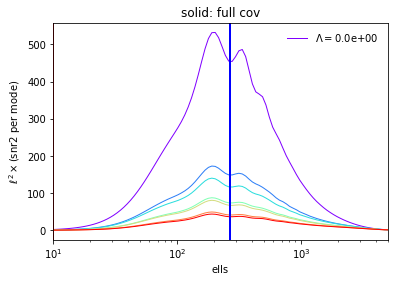

In [24]:
plt.figure(facecolor = 'w')

for Lambda_idx, Lambda in enumerate(_Lambdas):
    label = None
    if(Lambda == 0.0 or Lambda == 1e-1):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_full[Lambda], 
             label=label, lw = 1, c=rainbow_colors[Lambda_idx])
    plt.axvline(ell_fundamental, c='r')
    plt.axvline(ell_max_survey, c='b')

#     plt.plot(ells, ells**2 * SNR2_per_mode_noise_dom[Lambda], 
#              lw = 1, ls='--', c=rainbow_colors[Lambda_idx])

plt.xscale('log')
plt.xlabel('ells')
plt.title('solid: full cov')#\ndashed: noise dominated')
plt.ylabel(r'$\ell^2\times$(snr2 per mode)')
plt.xlim(min(ells), max(ells))
plt.legend(frameon=False)

In [25]:
SNR2_per_Omega_full      = np.zeros(len(_Lambdas))
SNR2_per_Omega_noise_dom = np.zeros(len(_Lambdas))
SNR2_per_Omega_fullsky   = np.zeros(len(_Lambdas))

_idxs = np.where((ells >= ell_fundamental) & (ells <= ell_max_survey))
for Lambda_idx,Lambda in enumerate(_Lambdas):
    SNR2_per_Omega_noise_dom[Lambda_idx] = trapezoid(x = np.log(ells)[_idxs], 
                                                     y = SNR2_per_mode_noise_dom[Lambda][_idxs] 
                                                     * ells[_idxs] ** 2 
                                                     / 2 / np.pi)
    
    SNR2_per_Omega_full[Lambda_idx] = trapezoid(x = np.log(ells)[_idxs], 
                                                y = SNR2_per_mode_full[Lambda][_idxs] 
                                                * ells[_idxs] ** 2 
                                                / 2 / np.pi)
    SNR2_per_Omega_fullsky[Lambda_idx] = trapezoid(x = np.log(ells), 
                                                y = SNR2_per_mode_full[Lambda] 
                                                * ells ** 2 
                                                / 2 / np.pi)


In [26]:
Omega_field

array(9.44314001)

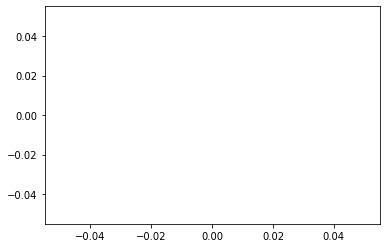

In [27]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": "11",
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in'
})

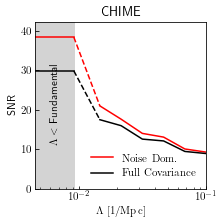

In [28]:
plt.figure(figsize = (3,3), facecolor = 'w')


plt.plot(_Lambdas[1:], np.sqrt(SNR2_per_Omega_noise_dom * Omega_field)[1:], 
         c='r',
#             marker='+',s=50,
        label='Noise Dom.')

plt.plot(_Lambdas[1:], np.sqrt(SNR2_per_Omega_full * Omega_field)[1:], 
         c='k',
#             marker='x', s=50,
        label='Full Covariance')

# plt.plot(_Lambdas[1:], np.sqrt(SNR2_per_Omega_fullsky * 4*np.pi)[1:], 
#          c='lightgrey',
# #             marker='x', s=50,
#         label='Full Sky')



plt.plot([kpar_fundamental, _Lambdas[1]], np.sqrt(SNR2_per_Omega_full * Omega_field)[:2], 
         c='k', ls='--',)

plt.plot([kpar_fundamental, _Lambdas[1]], np.sqrt(SNR2_per_Omega_noise_dom * Omega_field)[:2], 
         c='r', ls='--',)

# plt.plot([kpar_fundamental, _Lambdas[1]], np.sqrt(SNR2_per_Omega_fullsky * 4*np.pi)[:2], 
#          c='lightgrey', ls='--',)


unfiltered_SNR_noisedom = np.sqrt(SNR2_per_Omega_noise_dom[0] * Omega_field)
unfiltered_SNR_full = np.sqrt(SNR2_per_Omega_full[0] * Omega_field)
plt.plot([0, kpar_fundamental], [unfiltered_SNR_full, unfiltered_SNR_full],
         c='k',)

plt.plot([0, kpar_fundamental], [unfiltered_SNR_noisedom, unfiltered_SNR_noisedom],
         c='r',)



plt.xscale('log')
plt.fill_between([0, kpar_fundamental], [0,0], [10000, 10000],
                color = 'lightgrey', )

bnd_center = np.sqrt(1/2*kpar_fundamental**2)
hcenter = (unfiltered_SNR_noisedom * 1.1)/2
plt.text(bnd_center, hcenter,
        r'$$ \hspace{1em}\Lambda < \textsf{Fundamental}$$', 
        ha='center',
        va='center',
        rotation='vertical',)


plt.ylim(0, unfiltered_SNR_noisedom * 1.1)

plt.xlim(kpar_fundamental/2, 1e-1)


plt.xlabel(r'$\Lambda$ [1/Mpc]')
plt.ylabel(r'$\textsf{SNR}$')

plt_title = r'\textsf{%s}'%(experiment)
    
plt.title(plt_title)
plt.legend(frameon=False, loc='lower right')

fig_fname = 'figures/011.006.%s.pdf'%(experiment)
plt.savefig(fig_fname)

In [29]:
SNR_detect = 10
noise_dom_y = np.zeros(len(_Lambdas))
full_y = np.zeros(len(_Lambdas))

for i,Lambda in enumerate(_Lambdas):
    
    def SNR2_for_Omega_sky(Omega_sky, full=True):
        #assume Omega_sky in rad^2
        _ell_fundamental = np.sqrt((2*np.pi)**2 / Omega_sky)
        _ell_fundamental = max(np.array(ell_fundamental), 10)
        _idxs = np.where((ells >= _ell_fundamental) & (ells <= ell_max_survey))
        
        if(full):
            return trapezoid(x = np.log(ells)[_idxs], 
                         y = SNR2_per_mode_full[Lambda][_idxs] 
                         * ells[_idxs] ** 2 
                         / 2 / np.pi) * Omega_sky
        
        return trapezoid(x = np.log(ells)[_idxs], 
                         y = SNR2_per_mode_noise_dom[Lambda][_idxs] 
                         * ells[_idxs] ** 2 
                         / 2 / np.pi) * Omega_sky
    
    def find(full):
        Omega_min = 1e-20
        Omega_max = 4 * np.pi * 100 #not physical to go beyond full sky but for binary search    

        tolerance = 1e-6
        max_iterations = 100
        target_SNR2 = SNR_detect**2
        for iteration in range(max_iterations):
            Omega_mid = (Omega_min + Omega_max) / 2
            SNR2_mid = SNR2_for_Omega_sky(Omega_mid, full=full)
            if abs((SNR2_mid - target_SNR2)/target_SNR2) < tolerance:
                Omega_sky_solution = Omega_mid
                break

            if SNR2_mid < target_SNR2:
                Omega_min = Omega_mid
            else:
                Omega_max = Omega_mid
        else:
            print('couldnt converge')
            assert(1==0)
        return Omega_mid
    
    noise_dom_y[i] = find(full=False)#/(4*np.pi)
    noise_dom_y[i] *= (180/np.pi)**2 #deg2
    
    full_y[i] = find(full=True)#/(4*np.pi)
    full_y[i] *= (180/np.pi)**2 #deg2


In [30]:
fid = Omega_field * (180/np.pi)**2
full_sky_deg2 = 4*np.pi * (180/np.pi)**2

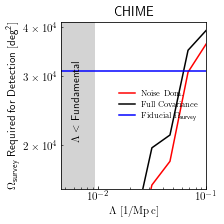

In [32]:
fig = plt.figure(figsize = (3,3), facecolor = 'w')
plt.tick_params(axis='both', direction='in')

plt.plot(_Lambdas[1:], noise_dom_y[1:], 
         c='r',
        label='Noise Dom.')

plt.plot(_Lambdas[1:], full_y[1:], 
         c='k',
        label='Full Covariance')



plt.plot([kpar_fundamental, _Lambdas[1]], full_y[:2], 
         c='k', ls='--',)

plt.plot([kpar_fundamental, _Lambdas[1]], noise_dom_y[:2], 
         c='r', ls='--',)


unfiltered_SNR_noisedom = noise_dom_y[0]
unfiltered_SNR_full = full_y[0]
plt.plot([0, kpar_fundamental], [unfiltered_SNR_full, unfiltered_SNR_full],
         c='k',)

plt.plot([0, kpar_fundamental], [unfiltered_SNR_noisedom, unfiltered_SNR_noisedom],
         c='r',)


plt.xscale('log')
plt.fill_between([0, kpar_fundamental], [0,0], [full_sky_deg2, full_sky_deg2],
                color = 'lightgrey', )


ymax = full_y[-1] * 1.1
bnd_center = np.sqrt(1/2*kpar_fundamental**2)
# hcenter = (ymax * 1.1)/2
hcenter = np.sqrt(ymax * fid/2)

plt.text(bnd_center, hcenter,
        r'$$ \hspace{1em}\Lambda < \textsf{Fundamental}$$', 
        ha='center',
        va='center',
        rotation='vertical',)


plt.ylim(fid/2, min(full_sky_deg2, ymax))
plt.yscale('log')
plt.xlim(kpar_fundamental/2, 1e-1)

plt.axhline(fid, c='b', label=r'Fiducial $\Omega_{\sf survey}$')

plt.xlabel(r'$\Lambda$ [1/Mpc]')
plt.ylabel(r'$\Omega_{\sf survey}\textsf{ Required for Detection}\ [\sf deg^2]$')



plt_title = r'\textsf{%s}'%(experiment)
plt.title(plt_title)


plt.legend(frameon=False, fontsize=8, loc='center right')
fig_fname = 'figures/011.006.aspir_%s.pdf'%(experiment)
plt.savefig(fig_fname)